In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv('processed_data/computation_courses.csv').drop_duplicates('course name').sort_values('course name')

#df = df[df['filename'].str.contains('STAT')|df['text'].str.lower().str.contains('statistics')]
#df = df[df['course name'].str.contains('STAT')]
print(df.shape[0])
df


257


,filename,course department,course name,Name,text,cleaned_text
66,APCOMP 209A_COMPSCI 1090A_COMPSCI 109A_STAT 10...,APCOMP,APCOMP 209A,APCOMP 209A/COMPSCI 1090A/COMPSCI 109A/STAT 10...,Introduction to Data Science (F all 2024)\nCS ...,Introduction to Data Science (F all 2024) CS 1...
37,APCOMP 209B_COMPSCI 109B_STAT 109B_STAT 121B -...,APCOMP,APCOMP 209B,APCOMP 209B/COMPSCI 109B/STAT 109B/STAT 121B: ...,Draft Syllabus Subject to Change\nAdvanced T o...,Draft Syllabus Subject to Change Advanced T op...
183,APCOMP 215 - 2024 Fall (215121).pdf,APCOMP,APCOMP 215,APCOMP 215: Advanced Practical Data Science,Official\tweb\tpage:\t\nhttps://harvard-iacs.g...,Official web page: https://harvard-iacs.github...
19,APCOMP 221 - 2024 Spring (207093).pdf,APCOMP,APCOMP 221,APCOMP 221: Critical Thinking in Data Science,This\tcourse\texamines\tthe\twide-ranging\timp...,This course examines the wide-ranging impact d...
160,APCOMP 227_APMTH 227 - 2019 Fall (207546).pdf,APCOMP,APCOMP 227,APCOMP 227/APMTH 227: Computational Methods in...,Computational methods for the\nphysical scienc...,Computational methods for the physical science...
...,...,...,...,...,...,...
130,STAT 388R - 2017 Spring (204453).pdf,STAT,STAT 388R,STAT 388R: Design and Analysis of Experiments ...,STAT\t388R\nHarvard\tCollege/Graduate\tSchool\...,STAT 388R Harvard College/Graduate School of A...
165,STAT 98 - 2024 Spring (127768).pdf,STAT,STAT 98,STAT 98: Tutorial - Junior Year,Statistics 98: Junior Tutorial\nSpring 2024 Sy...,Statistics 98: Junior Tutorial Spring 2024 Syl...
182,STAT 99R - 2024 Fall (159964).pdf,STAT,STAT 99R,STAT 99R: Tutorial - Senior Year,Full\tguidance\ton\tthe\tStatistics\trequireme...,Full guidance on the Statistics requirements f...
286,SYSBIO 220_SYSBIO 320_SYSBIO 320QC - 2019 Spri...,SYSBIO,SYSBIO 220,SYSBIO 220: Analysis foundations for quantitat...,SB220 Quantitative Measurement and Analysis – ...,SB220 Quantitative Measurement and Analysis – ...


In [5]:
documents = df['cleaned_text'].values

In [6]:
ls = []
vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=10,
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z]+\b'  # Only keep words with alphabetic characters
)
doc_term_matrix = vectorizer.fit_transform(documents)
    
for num_topics in np.arange(2,10):
    N = 10
    # Vectorize text
    
    # Fit LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)
    
    topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    
    top_words = np.argsort(topic_word_distributions, axis=1)[:, -N:]
    vocabulary = np.array(vectorizer.get_feature_names_out())
    topic_top_words = vocabulary[top_words]
    
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Example: Cosine similarity between word distributions
    def coherence_score(topic_words, doc_term_matrix):
        scores = []
        for words in topic_words:
            word_indices = [vectorizer.vocabulary_[w] for w in words if w in vectorizer.vocabulary_]
            sub_matrix = doc_term_matrix[:, word_indices].toarray()
            similarities = cosine_similarity(sub_matrix.T)
            upper_tri_indices = np.triu_indices_from(similarities, k=1)
            scores.append(similarities[upper_tri_indices].mean())
        return np.mean(scores)
    
    coherence = coherence_score(topic_top_words, doc_term_matrix)
    ls.append(coherence)
    print(num_topics, np.round(coherence,3), np.round(lda.perplexity(doc_term_matrix),1))


2 0.485 896.0
3 0.473 869.3
4 0.439 845.4
5 0.489 832.8
6 0.484 830.5
7 0.483 837.3
8 0.474 836.2
9 0.484 843.3


In [7]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Display the topics
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}: ", [feature_names[i] for i in topic.argsort()[-10:]])

Topic 1:  ['hours', 'final', 'exam', 'week', 'homework', 'notes', 'pm', 'edu', 'harvard', 'lecture']
Topic 2:  ['algebraic', 'groups', 'class', 'algebra', 'topics', 'geometry', 'quantum', 's', 'math', 'theory']
Topic 3:  ['material', 'students', 'time', 'exam', 'problems', 'work', 'homework', 'problem', 'class', 'math']
Topic 4:  ['s', 'learning', 'final', 'project', 'data', 'work', 'assignments', 'harvard', 'class', 'students']
Topic 5:  ['analysis', 's', 'learning', 'e', 'statistical', 'et', 'al', 'j', 'inference', 'data']


In [135]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

# Assuming `doc_term_matrix` is your document-term matrix
# Fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

# Get the topic distribution for each document
doc_topic_distribution = lda.transform(doc_term_matrix)  # Shape: [n_docs, n_topics]

# Find the most representative document for each topic
def find_representative_documents(doc_topic_distribution, top_n=1):
    """
    Find the most representative documents for each topic.

    Parameters:
        doc_topic_distribution: ndarray
            The topic distribution for each document (output of LDA's `transform` method).
        top_n: int
            Number of top documents to find for each topic.

    Returns:
        dict: A dictionary where keys are topic IDs and values are lists of document indices.
    """
    n_topics = doc_topic_distribution.shape[1]
    representative_docs = {}

    for topic_id in range(n_topics):
        # Get the indices of the top-n documents for this topic
        top_docs = np.argsort(doc_topic_distribution[:, topic_id])[-top_n:][::-1]
        representative_docs[topic_id] = top_docs.tolist()

    return representative_docs

# Find the most representative documents for each topic
top_n = 5  # Change to 2, 3, etc., for more representative documents
representative_docs = find_representative_documents(doc_topic_distribution, top_n)

# Display results
for topic, docs in representative_docs.items():
    print(f"Topic {topic+1}: Document indices {docs}")
    for doc in docs:
        print(documents[doc][:200])
        print('----')

Topic 1: Document indices [228, 202, 97, 77, 91]
Statistics 171: Stochastic Processes, Spring 2024 Course Description and Goals: Stochastic processes collectively describe various random phenomena arising in nature and our daily life. We will study 
----
Course description: This course is an undergraduate-level course on electromagnetism. Topics include electrostatics, electric currents, magnetic field, electromagnetic induction, Maxwell's equations, 
----
Lecture notes (Updated 12/1) Class time : Tuesday and Thursday 3:00-4:15 pm, EST. Office hours : This week : Friday Dec 11, 1:30-3:00 pm EST, or by appointment. Zoom link (for classes and office hours
----
CA office hours are 7:30-9:15pm on Tuesday nights and 3:30-5:30pm Wednesday afternoons in the Kirkland house dining hall. Lecture notes on the mathematical happenings in class can be found in the file
----
Lucy (she/her/hers) - lucyvuong@college.harvard.edu OH: Wednesday 2:45 - 3:45 PM (Math Lounge); Wednesday 8:30 - 9:30 PM (Rothe

In [16]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to calculate exclusivity of words across topics
def get_anchor_words_exclusive(topic_word_matrix, feature_names, top_n=10, exclusivity_threshold=0.8):
    n_topics, n_words = topic_word_matrix.shape
    anchor_words = {}

    # Normalize topic-word probabilities to convert them into probabilities
    topic_word_probs = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)

    # For each topic, find anchor words
    for topic_idx in range(n_topics):
        topic_probs = topic_word_probs[topic_idx]
        exclusivity_scores = topic_probs / topic_word_probs.sum(axis=0)  # Score for each word
        
        # Select words based on exclusivity scores and top probabilities
        candidate_indices = topic_probs.argsort()[::-1]  # Sort words by topic probability
        exclusive_words = [
            feature_names[i]
            for i in candidate_indices
            if exclusivity_scores[i] >= exclusivity_threshold
        ][:top_n]
        
        anchor_words[f"Topic {topic_idx}"] = exclusive_words

    return anchor_words

# Example usage: Assuming 'lda' is the trained LDA model and 'vectorizer' is the CountVectorizer
topic_word_matrix = lda.components_  # Shape: [n_topics, n_words]
feature_names = vectorizer.get_feature_names_out()

# Parameters
top_n = 50
exclusivity_threshold = 0.8  # A word must have at least 80% exclusivity for one topic to qualify

anchor_words = get_anchor_words_exclusive(topic_word_matrix, feature_names, top_n, exclusivity_threshold)

# Display anchor words
for topic, words in anchor_words.items():
    print(f"{topic}: {', '.join(words)}")


Topic 0: feb, apr, october, january, law, dining, noon, schemes, saturday, bayes, typeset, handwritten
Topic 1: quantum, geometry, algebraic, topology, manifolds, spaces, dynamical, representation, computation, analytic, complexity, geometric, theorems, finite, representations, graphs, varieties, curves, spectral, bundles, arithmetic, abelian, inequalities, fourier, symmetry, topological, lie, rings, surfaces, notions, inequality, relations, classification, categories, tensor, maps, projective, derived, rational, sheaves, hilbert, undergraduates, riemann, dimensions, cohomology, construction, category, polynomials, dimension, polynomial
Topic 2: ll, solving, solve, don, multivariable, assessments, cas, scheme, extenuating, explaining, fun, welcoming
Topic 3: coding, gai, diversity, comments, honor, speak, notebook, campus, gender, plagiarism, anonymous, thoughts, confidential, significant, needing, adhere, dishonesty, pairs, honesty, cheating, scholarly, contribution
Topic 4: inference

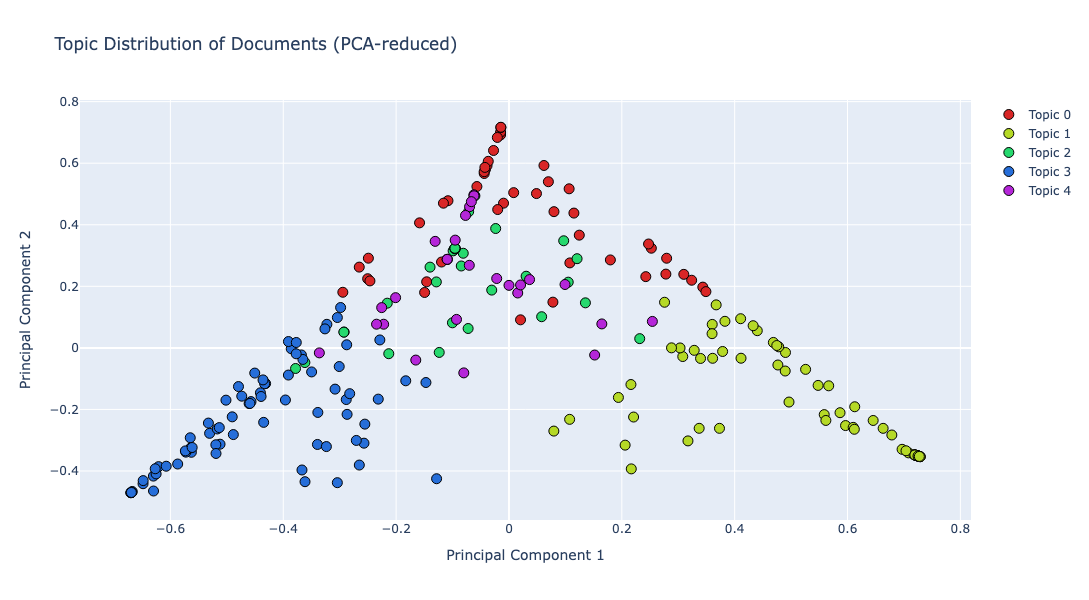

In [21]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Assuming df['Name'] and lda model are already defined
# Step 1: Transform document-term matrix using LDA
doc_topic_distribution = lda.transform(doc_term_matrix)  # Shape: [n_docs, n_topics]

# Step 2: Determine the dominant topic for each document
dominant_topics = np.argmax(doc_topic_distribution, axis=1)  # Majority topic for each document

# Step 3: Add dominant topic to DataFrame for reference
df['Dominant Topic'] = dominant_topics

# Step 4: Reduce topic distribution to 2D using PCA for visualization
pca = PCA(n_components=2)
topic_distribution_2d = pca.fit_transform(doc_topic_distribution)  # Shape: [n_docs, 2]

# Step 5: Define a color palette for topics
num_topics = lda.n_components
colors = [f"hsl({i * 360 / num_topics}, 70%, 50%)" for i in range(num_topics)]  # HSL for distinct colors

# Step 6: Create an interactive scatter plot
fig = go.Figure()

# Add scatter plot, grouping by dominant topic for coloring
for topic_id in range(num_topics):
    indices = dominant_topics == topic_id
    fig.add_trace(go.Scatter(
        x=topic_distribution_2d[indices, 0],
        y=topic_distribution_2d[indices, 1],
        mode='markers',
        name=f"Topic {topic_id}",
        text=df.loc[indices, 'Name'],  # Use course names for hover text
        hovertemplate=(
            "<b>Course Name:</b> %{text}<br>" +
            "<b>Topic:</b> %{meta}"  # Include topic number in hover
        ),
        meta=[f"Topic {topic_id}" for _ in range(sum(indices))],
        marker=dict(
            size=10,
            color=colors[topic_id],
            line=dict(width=1, color='black')
        )
    ))

# Step 7: Update layout
fig.update_layout(
    title="Topic Distribution of Documents (PCA-reduced)",
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    template="plotly",
    showlegend=True,
    width=1000,  # Width of the plot (in pixels)
    height=600   # Height of the plot (in pixels)
)

# Show the plot
fig.show()

In [24]:
df[df['filename'].str.contains('MATH 273X')]['Name'].values

array(['MATH 273X: Distributions of Class Groups of Global Fields'],
      dtype=object)

In [122]:
from bertopic import BERTopic
from umap import UMAP

from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#vectorizer_model = CountVectorizer(stop_words="english")
#topic_model = BERTopic(vectorizer_model=vectorizer_model)

In [123]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
topic_model = BERTopic(ctfidf_model=ctfidf_model, top_n_words = 100, calculate_probabilities = True)

In [124]:
topics, probs = topic_model.fit_transform(documents)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31,-1_the_and_to_will,"[the, and, to, will, of, in, lecture, be, you,...",[STAT 114: Introduction to Bioinformatics and ...
1,0,160,0_and_the_to_of,"[and, the, to, of, in, you, for, will, be, cou...",[Introduction to Data Science (F all 2024) CS ...
2,1,51,1_geometry_of_algebraic_the,"[geometry, of, algebraic, the, theory, will, a...","[Recently, there has been a surge of interest ..."
3,2,15,2_quantum_of_theory_the,"[quantum, of, theory, the, physics, in, mechan...",[Math262a: Quantum theory from a geometric vie...


In [125]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
#topic_model.save("BERT_v1_classtfidf", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)
#topic_model2 = BERTopic.load("BERT_v1_classtfidf")
topic_model2 = topic_model

In [126]:
topic_distribution, _ = topic_model2.approximate_distribution(documents)
pca = PCA(n_components=2)
topic_distribution_2d = pca.fit_transform(topic_distribution)

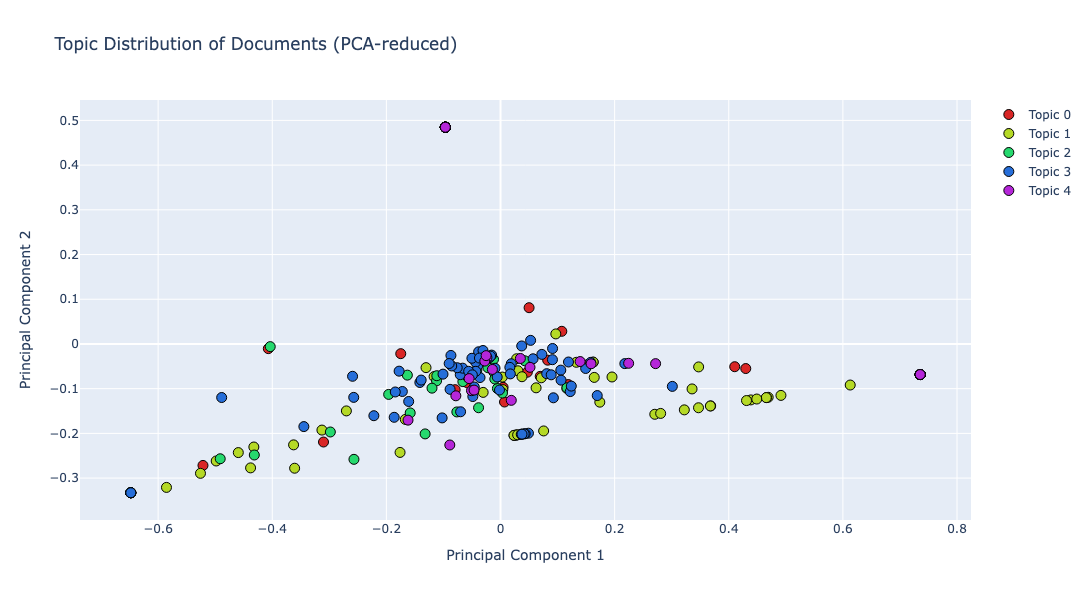

In [127]:
# Step 6: Create an interactive scatter plot
fig = go.Figure()

# Add scatter plot, grouping by dominant topic for coloring
for topic_id in range(num_topics):
    indices = dominant_topics == topic_id
    fig.add_trace(go.Scatter(
        x=topic_distribution_2d[indices, 0],
        y=topic_distribution_2d[indices, 1],
        mode='markers',
        name=f"Topic {topic_id}",
        text=df.loc[indices, 'Name'],  # Use course names for hover text
        hovertemplate=(
            "<b>Course Name:</b> %{text}<br>" +
            "<b>Topic:</b> %{meta}"  # Include topic number in hover
        ),
        meta=[f"Topic {topic_id}" for _ in range(sum(indices))],
        marker=dict(
            size=10,
            color=colors[topic_id],
            line=dict(width=1, color='black')
        )
    ))

# Step 7: Update layout
fig.update_layout(
    title="Topic Distribution of Documents (PCA-reduced)",
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    template="plotly",
    showlegend=True,
    width=1000,  # Width of the plot (in pixels)
    height=600   # Height of the plot (in pixels)
)

# Show the plot
fig.show()

In [128]:
def find_unique_anchor_words_bertopic(model, top_n=100):
    """
    Extract unique anchor words for each topic in a BERTopic model.

    Parameters:
        model: BERTopic object
            A trained BERTopic model.
        top_n: int
            Number of top words to consider per topic.

    Returns:
        dict: A dictionary where keys are topic IDs and values are lists of unique anchor words.
    """
    topics = model.get_topics()
    word_to_topic = {}

    # Map each word to the list of topics it appears in
    for topic_id, terms in topics.items():
        for term, _ in terms[:top_n]:
            if term not in word_to_topic:
                word_to_topic[term] = set()
            word_to_topic[term].add(topic_id)

    # Filter words that belong to only one topic
    anchor_words = {topic_id: [] for topic_id in topics.keys()}
    for word, topic_ids in word_to_topic.items():
        if len(topic_ids) == 1:  # The word is unique to one topic
            unique_topic = list(topic_ids)[0]
            anchor_words[unique_topic].append(word)

    return anchor_words
find_unique_anchor_words_bertopic(topic_model2 , top_n=15)

{-1: ['lecture', 'are'],
 0: ['your', 'with'],
 1: ['geometry', 'algebraic', 'topology', 'groups'],
 2: ['quantum', 'physics', 'mechanics']}

In [97]:
print(df[df['filename'].str.contains('STAT 123')]['Name'].values)
print(df[df['filename'].str.contains('STAT 123')]['cleaned_text'].values)

['STAT 123: Applied Quantitative Finance']
["Thank you for taking Stat 123 2022, Quantitative Finance. Thank you for a great semester. With best wishes for the future, Cheers Stephen Administrative Course Logistics Syllabus Textbook FAQ Course Materials Homework Homework Solutions Sample Midterm Exams Midterm Solutions Final Exam Review Materials Final Review Sections Schedule Team Member Time Location Raj Bhuptani Saturday , April 30, 2pm-4pm Science Center 705 Carolyn Ge Monday, May 2 11am-1pm Science Center 222 Rachel Li Thursday, 4/28, 9-11am Science Center 309A Victor Li Tuesday, May 3 2-4PM Science Center 309A Ramiz Razzak Saturday 4/30, 3-5PM Science Center 316 Peter Shim Thursday, April 28 1-3 PM Science Center 316 RunLin Wang Wednesday, May 4, 1-3 PM Science Center 222 Iris Xu Thursday, May 5, 10 AM - 12 PM Science Center 705 Xin Zeng Friday, April 29, 1 - 3PM Science Center 222 Sections and Teaching Team Office Hours Team Member Time Location Raj Bhuptani Section Sunday 4-5pm